#### Trabajo Práctico 2 : Críticas Cinematográficas

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

# Setup

In [3]:
#!pip install -r ./torch-cuda-118.txt
!pip install -r ./requirements.txt
#!python -m spacy download es_dep_news_trf

### Cargar bibliotecas

In [1]:
import sklearn
import joblib
import pandas as pd
import tensorflow as tf
import plotly as py
import numpy as np
import langdetect
#import spacy     # Disable because incompatibilities with tensorflow and CuDNN
import unicodedata
import nltk
import string
import re

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn import metrics
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#from pysentimiento import create_analyzer
#import transformers

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Show availables GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", len(physical_devices))
print(tf.__version__)

2023-06-29 13:39:31.526226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 13:39:32.054522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Available GPUs: 1
2.12.0


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-06-29 13:39:32.988232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 13:39:33.000530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Docu

### Cargar dataset

In [113]:
ds = pd.read_csv("datasets/train.csv")
ds_test = pd.read_csv("datasets/test.csv")
print(ds.head())

   ID                                          review_es sentimiento
0   0  Uno de los otros críticos ha mencionado que de...    positivo
1   1  Una pequeña pequeña producción.La técnica de f...    positivo
2   2  Pensé que esta era una manera maravillosa de p...    positivo
3   3  Básicamente, hay una familia donde un niño peq...    negativo
4   4  El "amor en el tiempo" de Petter Mattei es una...    positivo


# Visualización de los datos

In [112]:
x = ds['sentimiento'].value_counts()
fig = py.graph_objs.Figure([py.graph_objs.Bar(x=x.index, y=x.values)])
fig.update_layout(title_text='Distribución de criticas positivas y negativas')
fig.show()

Observamos el gráfico y confirmamos que es un data set balanceado. No hará falta hacer over o undersampling.

## Preprocesamiento general

In [114]:
reviews = ds["review_es"]
reviews_test = ds_test["review_es"]
sentiments = [1 if sentiment == "positivo" else 0 for sentiment in ds["sentimiento"]]

## Preprocesamiento de datos opcion 1

In [71]:
# ELiminacion de stopwords 1
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

vectorizador = CountVectorizer(stop_words=stopwords.words('spanish'))
reviews_vectorized = vectorizador.fit_transform(reviews)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
#Reviews sin stop words 2 (mejor)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

vectorizador = CountVectorizer()

# Tokenizacion
tokenized_reviews = [word_tokenize(review) for review in reviews]

# Filtrado de stop words
filtered_reviews = []
stop_words = set(stopwords.words('spanish'))

for review in tokenized_reviews:
    filtered_review = [word for word in review if word.lower() not in stop_words]
    filtered_reviews.append(" ".join(filtered_review))

# Aplicar la vectorización a las críticas filtradas
reviews_vectorized = vectorizador.fit_transform(filtered_reviews)


In [163]:
#Vectorizacion sin eliminacion de stop words
vectorizador = CountVectorizer()
reviews_vectorized = vectorizador.fit_transform(reviews)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(reviews_vectorized, sentiments, test_size=0.2, random_state=42)

In [26]:
print(sum(y_train) / len(y_train))

0.499025


In [27]:
X_train.shape

(40000, 175807)

## Preprocesamiento de datos opcion 2

Vectorizacion de solo las palabras que aparecen en test y train. Y que no incluyan stop words

In [77]:
# Cargado de stop words externo

with open("stopwords/spanish.txt", "r", encoding="utf-8") as file:
    content = file.read()
stop_words_es = content.splitlines()
stop_words_es = [word.strip() for word in stop_words_es]
stop_words_es = [word.lower() for word in stop_words_es]

# Vimos que hay muchas palabras en ingles

with open("stopwords/english.txt", "r", encoding="utf-8") as file:
    content = file.read()
stop_words_en = content.splitlines()
stop_words_en = [word.strip() for word in stop_words_en]
stop_words_en = [word.lower() for word in stop_words_en]

stop_words = stop_words_en + stop_words_es


In [116]:
vectorizer = CountVectorizer()

# Palabras unicas de las reviwes de train
vectorizer.fit(reviews)
train_unique_words = vectorizer.vocabulary_.keys()

# Palabras unicas de las reviews de test
vectorizer.fit(reviews_test)
test_unique_words = vectorizer.vocabulary_.keys()


In [117]:
common_words = list(set(test_unique_words) & set(train_unique_words))


In [119]:
len(common_words)

33665

In [122]:
vectorizador = CountVectorizer(stop_words=stop_words, vocabulary=common_words)
reviews_vectorized = vectorizador.fit_transform(reviews)

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan'] not in stop_words.



In [123]:
X_train, X_test, y_train, y_test = train_test_split(reviews_vectorized, sentiments, test_size=0.2, random_state=42)

In [124]:
X_train.shape

(40000, 33665)

# Entrenamiento de modelos

## Bernoulli

In [5]:
# Cantidad de reseñas que no estan en español
def count_non_spanish(reviews):
    non_spanish_count = 0
    for review in reviews:
        if langdetect.detect(review) != 'es': non_spanish_count += 1
    return non_spanish_count

non_spanish_count = count_non_spanish(ds['review_es'])
spanish_count = len(ds['review_es']) - non_spanish_count
non_spanish_bar = py.graph_objs.Bar(x=["Reseñas en otro idioma"], y=[non_spanish_count])
spanish_bar = py.graph_objs.Bar(x=["Reseñas en español"], y=[spanish_count])
fig = py.graph_objs.Figure([spanish_bar, non_spanish_bar])
fig.update_layout(title_text='Distribución de reseñas en español y no español')
fig.show()

# Preprocesamiento de datos

In [7]:
ds = pd.read_csv("datasets/train.csv")

ascii_chars = set(string.printable)
stop_words = set(stopwords.words("spanish"))
#nlp = spacy.load('es_dep_news_trf')

# Compile regex
url_regex = re.compile(r'http:?\S+')
non_ascii_regex = re.compile('[^a-z0-9 \n\.]')
double_space_regex = re.compile(' +')

def _remove_punctuation(review):
    punctuation_chars = ".:,;\n!|?¿¡"
    translator = str.maketrans('', '', punctuation_chars)
    review = review.translate(translator)
    return review

def _remove_single_char_word(review):
    words = review.split()
    words = [word for word in words if len(word) > 1]
    return ' '.join(words)

#def _lemmatize(review, print_msg=False):
#    if print_msg: print("Finished 100 reviews")
#    lemmatized = nlp(review)
#    lemas = [token.lemma_ for token in lemmatized]
#    return ' '.join(lemas)    

def _remove_urls(review):
    return url_regex.sub('', review)


def _remove_non_ascii(review):
    review = unicodedata.normalize('NFD', review)
    review = review.encode('ascii', 'ignore')
    review = review.decode("utf-8")
    review = non_ascii_regex.sub('', review)
    review = double_space_regex.sub(' ', review) # Removes double space
    return review

def _remove_stopwords(review):
    review_without_stopwords = []
    review_split = review.split()
    for word in review_split:
        if word in stop_words: continue
        review_without_stopwords.append(word)
    
    review = ' '.join(review_without_stopwords)
    return double_space_regex.sub(' ', review) # Removes double space

def clean_reviews(ds):
    ds_copy = ds.copy()
    ds_copy['review_es'] = ds_copy['review_es'].str.lower()
    print("Finished lowering")
    ds_copy['review_es'] = ds_copy['review_es'].apply(_remove_punctuation)
    print("Finished removing punctuation")
    ds_copy['review_es'] = ds_copy['review_es'].apply(_remove_urls)
    print("Finished removing urls")
    ds_copy['review_es'] = ds_copy['review_es'].apply(_remove_non_ascii)
    print("Finished removing non-ascii chars")
    #ds_copy['review_es'] = ds_copy['review_es'].apply(_remove_stopwords)
    #print("Finished removing stopwords")
    ds_copy['review_es'] = ds_copy['review_es'].apply(_remove_single_char_word)
    print("Finished removing one-char words")
    #ds_copy['review_es'] = ds_copy['review_es'].applt(_lemmatize)
    #print("Finished lemmatizing")
    return ds_copy

In [17]:
ds_cleaned = clean_reviews(ds)
ds_cleaned = ds_cleaned[ds_cleaned['review_es'].map(langdetect.detect) == 'es']
ds_cleaned['sentimiento'] = [1 if sentiment == "positivo" else 0 for sentiment in ds_cleaned['sentimiento']]
ds_cleaned.to_csv('datasets/train_preprocessed.csv', index=False)

Finished lowering
Finished removing punctuation
Finished removing urls
Finished removing non-ascii chars
Finished removing one-char words


# Entrenamiento de modelos

### Carga de Dataset preprocesado

In [2]:
ds = pd.read_csv("datasets/train_preprocessed.csv")
reviews = ds['review_es']
sentiments = ds['sentimiento']

vectorizer = CountVectorizer(stop_words=stopwords.words('spanish'))
reviews_vectorized = vectorizer.fit_transform(reviews)
X_train, X_test, y_train, y_test = train_test_split(reviews_vectorized, sentiments, test_size=0.2, random_state=42)

print(ds.head())

   ID                                          review_es  sentimiento
0   0  uno de los otros criticos ha mencionado que de...            1
1   1  una pequena pequena produccionla tecnica de fi...            1
2   2  pense que esta era una manera maravillosa de p...            1
3   3  basicamente hay una familia donde un nino pequ...            0
4   4  el amor en el tiempo de petter mattei es una p...            1


## Bernoulli

In [38]:
nb_model = BernoulliNB()
nb_model.fit(X_train, y_train)
joblib.dump(svm_classifier, f"models/bernoulli.pkl")

['models/bernoulli.pkl']

In [39]:
y_pred = nb_model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8466
Precision: 0.8670157068062827
Recall: 0.8215915856320699
F1 Score: 0.8436926839209293


In [10]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = nb_model.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/binomialNB.csv", index=False)

In [17]:
param_grid = {
    "alpha": [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    "binarize": [0.0, 0.5, 1.0, 2.0, 5.0, 10.0],
    "fit_prior": [True, False]
}

nb_model = BernoulliNB()
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, sentiments)

print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'alpha': 0.5, 'binarize': 0.0, 'fit_prior': True}


In [15]:
best_params = {'alpha': 0.5, 'binarize': 0.0, 'fit_prior': True}

In [16]:
nb_model = BernoulliNB(**best_params)
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8458
Precision: 0.8641949593834618
Recall: 0.8233776542964873
F1 Score: 0.8432926829268294


In [17]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = nb_model.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/binomialNB_best.csv", index=False)

## Pysentimiento

In [22]:
transformers.logging.set_verbosity(transformers.logging.ERROR)
analyzer = create_analyzer(task="sentiment", lang="es")

In [23]:
prediction = analyzer.predict(reviews[0])

print("positivo" if prediction.probas["POS"] > prediction.probas["NEG"] else "negativo")

negativo


In [24]:
test_ds = pd.read_csv("datasets/test.csv")
reviews = test_ds["review_es"].tolist()
for i in range(len(reviews)):
    prediction = analyzer.predict(reviews[i])
    test_ds.loc[i, "sentimiento"] = "positivo" if prediction.probas["POS"] > prediction.probas["NEG"] else "negativo"

test_ds[["ID","sentimiento"]].to_csv("submissions/pysentimiento.csv", index=False)


## Random Forest

In [17]:
#Random forest

FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = { 
    'n_estimators': [10, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfc = RandomForestClassifier(random_state=42)

gs = RandomizedSearchCV(rfc, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
gs.fit(X_train, sentiments)

Fitting 6 folds for each of 100 candidates, totalling 600 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 200, 300,
                                                         500]},
                   scoring=make_scorer(f1_score, zero_division=1), verbose=2)

In [19]:
print(gs.best_params_)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}


In [36]:
best_params = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}

rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)
joblib.dump(svm_classifier, f"models/randomforest.pkl")

['models/randomforest.pkl']

In [28]:
y_pred = rfc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8261
Precision: 0.810267017675818
Recall: 0.8551299861083548
F1 Score: 0.8320942357825625


In [30]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = rfc.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/randomforest.csv", index=False)

## Random forest con reviews sin stopwords

In [9]:
# Usamos k fold cross validation
FOLDS = 10
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = { 
    'n_estimators': [10, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8, 10],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Creacion del modelo
rfc = RandomForestClassifier()

# Busqueda de hiperparametros
rs = RandomizedSearchCV(rfc, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
rs.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 200, 300,
                                                         500]},
                   scoring=make_scorer(f1_score, zero_division=1), verbose=2)

In [10]:
print(rs.best_params_)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


In [11]:
# Guardamos los mejores parametros
best_params = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}

In [28]:
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [29]:
# Metricas sin stop words 2
# Este no subimos a kaggle porque era mejor el modelo sin stop words 1
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.83
Precision: 0.806949806949807
Recall: 0.8710061520142885
F1 Score: 0.8377552968123687


In [14]:
# Metricas sin stop words 1
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8334
Precision: 0.8113346870961787
Recall: 0.8721968644572335
F1 Score: 0.8406656465187453


Text(50.722222222222214, 0.5, 'True')

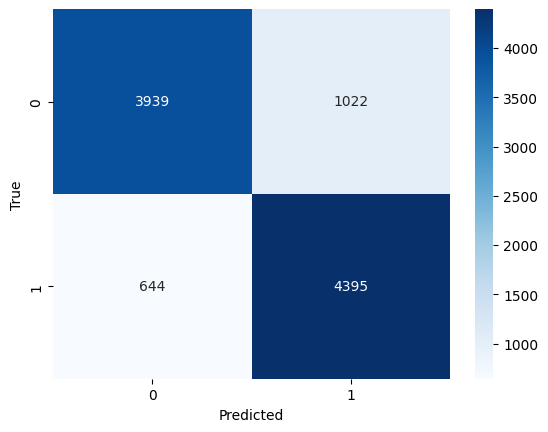

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [18]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = best_rf.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/randomforest2.csv", index=False)

In [19]:
joblib.dump(best_rf, f"models/randomforest2.pkl")

['models/randomforest2.pkl']

## Random Forest con preprocesamiento de datos 2

In [131]:
# Usamos k fold cross validation
FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = { 
    'n_estimators': [10, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8, 10],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Creacion del modelo
rfc = RandomForestClassifier()

# Busqueda de hiperparametros
rs = RandomizedSearchCV(rfc, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
rs.fit(X_train, y_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 200, 300,
                                                         500]},
                   scoring=make_scorer(f1_score, zero_division=1), verbose=2)

In [132]:
print(rs.best_params_)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}


In [133]:
# Guardamos los mejores parametros
best_params = {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}

In [134]:
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [135]:
# Metricas 
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8187
Precision: 0.7870106761565836
Recall: 0.8777535225243104
F1 Score: 0.8299089970916597


Text(50.722222222222214, 0.5, 'True')

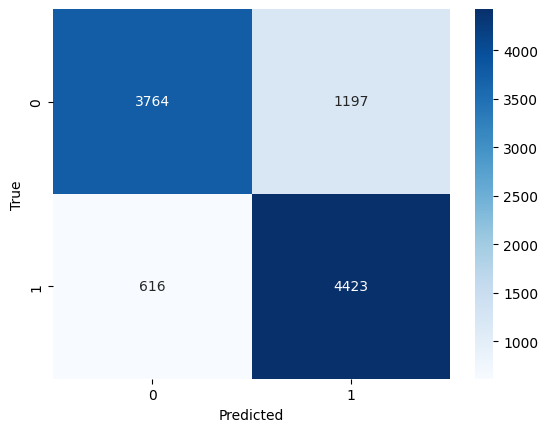

In [136]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [137]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = best_rf.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/randomforest4.csv", index=False)

In [138]:
joblib.dump(best_rf, f"models/randomforest4.pkl")

['models/randomforest4.pkl']

## XGBoost

In [15]:
# XGBoost
from xgboost import XGBClassifier

FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = {
    'n_estimators': [10, 100, 200, 300, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

xgb = XGBClassifier(random_state=42)

gs = RandomizedSearchCV(xgb, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
gs.fit(X_train, sentiments)

print(gs.best_params_)

Fitting 6 folds for each of 100 candidates, totalling 600 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time= 8.8min
[CV] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8; total time= 7.6min
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.6; total time=15.4min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, subsample=0.9; total time= 7.5min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.6; total time=13.0min
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=500, subsample=0.6; total time=16.0min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05,

In [17]:
from xgboost import XGBClassifier

xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


Accuracy: 0.8722
Precision: 0.8643673706645999
Recall: 0.8852947013296288
F1 Score: 0.8747058823529412


In [18]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = xgb.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/xgboost.csv", index=False)

## XGBoost sin stopwords

In [31]:

from xgboost import XGBClassifier

FOLDS = 10
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = {
    'n_estimators': [10, 100, 200, 300, 500],
    'max_depth': [4, 5, 6, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

xgb = XGBClassifier(random_state=42)

rs = RandomizedSearchCV(xgb, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
rs.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           impo...
                                           predictor=None, random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [4, 5, 6, 7, 8, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 100, 200, 300,
                                                         500],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
                   scoring=make_scorer(f1_score, zero_division=1), verbose=2)

In [32]:
print(rs.best_params_)

{'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [46]:
best_params = {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}

In [47]:
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [48]:
# Metricas
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8699
Precision: 0.8630536130536131
Recall: 0.8817225640007939
F1 Score: 0.8722882104643173


Text(50.722222222222214, 0.5, 'True')

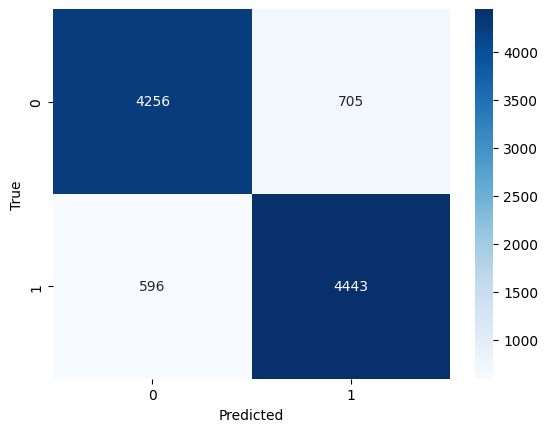

In [49]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [52]:
joblib.dump(xgb, f"models/xgboost3.pkl")

['models/xgboost3.pkl']

In [53]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = xgb.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/xgboost3.csv", index=False)

In [38]:
# Segundo intento con 4 folds
FOLDS = 4
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = {
    'n_estimators': [10, 100, 200, 300, 500],
    'max_depth': [4, 5, 6, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

xgb = XGBClassifier(random_state=42)

rs = RandomizedSearchCV(xgb, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
rs.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           impor...
                                           predictor=None, random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [4, 5, 6, 7, 8, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 100, 200, 300,
                                                         500],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
                   scoring=make_scorer(f1_score, zero_division=1), verbose=2)

In [39]:
print(rs.best_params_)

{'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7}


In [40]:
best_params ={'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7}

In [41]:
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [42]:
# Metricas
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8697
Precision: 0.8627184466019417
Recall: 0.8817225640007939
F1 Score: 0.8721169889096084


Text(50.722222222222214, 0.5, 'True')

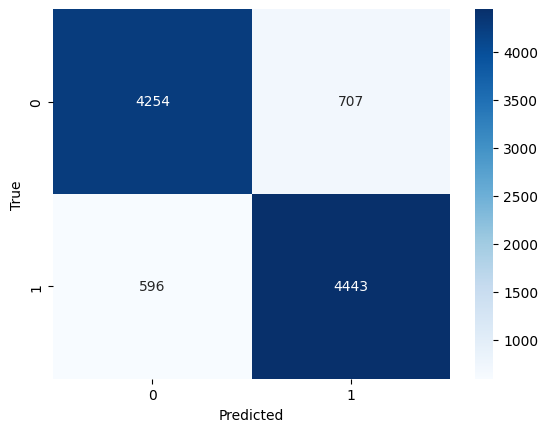

In [43]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [44]:
joblib.dump(xgb, f"models/xgboost4.pkl")

['models/xgboost4.pkl']

In [45]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = xgb.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/xgboost4.csv", index=False)

## XGBoost con preprocesamiento de datos 2

In [139]:
from xgboost import XGBClassifier

FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = {
    'n_estimators': [10, 100, 200, 300, 500],
    'max_depth': [4, 5, 6, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

xgb = XGBClassifier(random_state=42)

rs = RandomizedSearchCV(xgb, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
rs.fit(X_train, y_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           impor...
                                           predictor=None, random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [4, 5, 6, 7, 8, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 100, 200, 300,
                                                         500],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
                   scoring=make_scorer(f1_score, zero_division=1), verbose=2)

In [140]:
print(rs.best_params_)

{'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [141]:
best_params = {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}

In [142]:
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [143]:
# Metricas
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8544
Precision: 0.8488802336903603
Recall: 0.8650525897995635
F1 Score: 0.8568901120503245


Text(50.722222222222214, 0.5, 'True')

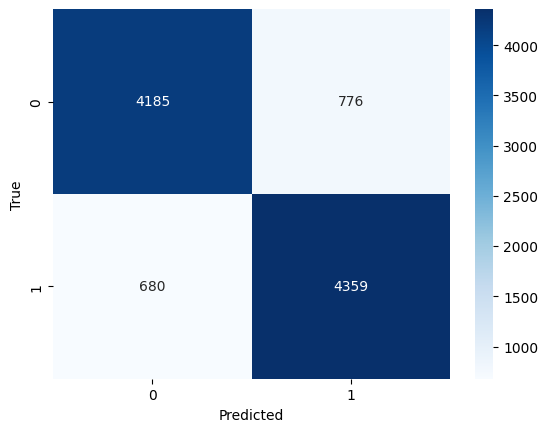

In [144]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [145]:
joblib.dump(xgb, f"models/xgboost5.pkl")

['models/xgboost5.pkl']

In [146]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds = clean_reviews(test_ds)
test_ds["sentimiento"] = xgb.predict(vectorizer.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/xgboost_preprocessed_stopwords.csv", index=False)

Finished lowering
Finished removing punctuation
Finished removing urls
Finished removing non-ascii chars
Finished removing stopwords
Finished removing one-char words


## SVM

In [14]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_classifiers = {}

for kernel in kernels:
    # Create an SVM classifier with the current kernel
    svm_classifier = svm.SVC(kernel=kernel)

    # Train the classifier on the training data
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the model
    print(sklearn.metrics.classification_report(y_test, y_pred))
    svm_classifiers[kernel] = svm_classifier

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      4961
           1       0.82      0.90      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4961
           1       0.88      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

              preci

In [17]:
# Guardamos los modelos entrenados

for kernel, svm_classifier in svm_classifiers.items():
    joblib.dump(svm_classifier, f"models/svm_classifier_{kernel}.pkl")

In [ ]:
test_ds = pd.read_csv("datasets/test.csv")
for classfier in svm_classifiers:
    test_ds["sentimiento"] = svm_classifiers[classfier].predict(vectorizador.transform(test_ds["review_es"]))
    # convert "sentimiento" to "positivo" or "negativo"
    test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
    test_ds[["ID","sentimiento"]].to_csv("submissions/svm_" + classfier + ".csv", index=False)

Observamos que el mejor fue el Radial Basis Function kernel, por lo que vamos a buscar hiperparámetros para ver si podemos mejorar ese.

In [19]:
# Observamos que el mejor fue el Radial Basis Function kernel, por lo que vamos a buscar hiperparámetros para ver si podemos mejorar ese.

FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score)

hiperparametros = {
    'C': [0.01, 0.1, 1, 2],
    'gamma': ["auto", "scale"],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5]
}

svm_classifier = svm.SVC()

gs = RandomizedSearchCV(svm_classifier, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=10)
gs.fit(X_train, sentiments)

print(gs.best_params_)

ValueError: Found input variables with inconsistent numbers of samples: [40000, 50000]

In [31]:
best_params = {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 1}
# Create the best SVM classfier
svm_classifier = svm.SVC(**best_params)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Save best SVM
joblib.dump(svm_classifier, f"models/svm_classifier_{best_params['kernel']}_best.pkl")

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8641
Precision: 0.8494113178883403
Recall: 0.887676126215519
F1 Score: 0.8681222707423581


In [33]:
# Make Kaggle predictions
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = svm_classifier.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/svm_rbf_best.csv", index=False)

## SVM con kernel radial sin stop words

In [54]:
FOLDS = 5
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score)

hiperparametros = {
    'C': [0.01, 0.1, 1, 2, 10],
    'gamma': ["auto", "scale"],
    'degree': [1, 2, 3, 4, 5],
    'kernel': 'rbf'
}

svm_classifier = svm.SVC()

rs = RandomizedSearchCV(svm_classifier, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=10)
rs.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 2, 10],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': ['auto', 'scale']},
                   scoring=make_scorer(f1_score), verbose=2)

In [55]:
print(rs.best_params_)

{'gamma': 'scale', 'degree': 1, 'C': 2}


In [56]:
best_params = {'gamma': 'scale', 'degree': 1, 'C': 2, 'kernel': 'rbf'}

In [57]:
svm_classifier = svm.SVC(**best_params)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

In [58]:
X_train.shape

(40000, 175807)

In [59]:
# Metricas
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8827
Precision: 0.8659598636879969
Recall: 0.9077197856717603
F1 Score: 0.8863482220715048


Text(50.722222222222214, 0.5, 'True')

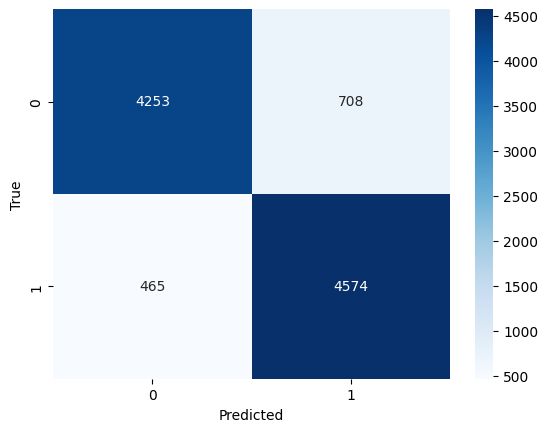

In [60]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [61]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = svm_classifier.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/svm_kr_sinstopwords.csv", index=False)

In [62]:
joblib.dump(svm_classifier, f"models/svm_kr_sinstopwords.pkl")

['models/svm_kr_sinstopwords.pkl']

## Ensamble de modelos

In [ ]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [ ]:
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier

#Modelos Base
base_models = {'random_forest':RandomForestClassifier(),
               'svm': svm.SVC(),
               'knn': KNeighborsClassifier()}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, X_train, y_train)
    model_scores[name] = scores

## Redes Neuronales

In [3]:
max_words = None # Numero de las palabras mas frecuentes a considerar
MAX_LEN = 500 # Longitud máxima de las secuencias

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
# Rellena o corta las secuencias al mismo tamaño
data = pad_sequences(sequences, maxlen=MAX_LEN)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(data, sentiments, test_size=0.2, random_state=42)
y_train_nn = np.array(y_train_nn)
y_test_nn = np.array(y_test_nn)

# Tamaño del vocabulario
vocabulary_size = len(tokenizer.word_index) + 1

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.callbacks import EarlyStopping
import numpy as np

# Definimos la arquitectura de la red neuronal
modelo = keras.Sequential([
    keras.layers.Embedding(input_dim=vocabulary_size, output_dim=1024, input_length=MAX_LEN),
    keras.layers.GRU(50, activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.GRU(50, activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.GRU(50, activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')  # Por ser problema de clasificación binaria 
])

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
modelo.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Usamos Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entramos al modelo
modelo.fit(X_train_nn, y_train_nn, epochs=20, batch_size=32, validation_data=(X_test_nn, y_test_nn), callbacks=[early_stopping])

# Evaluar el modelo
loss, accuracy = modelo.evaluate(X_test_nn, y_test_nn)
print("Loss:", loss)
print("Accuracy:", accuracy)


2023-06-29 13:40:56.960312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 13:40:56.960513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 13:40:56.960603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/20


2023-06-29 13:40:57.723434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 13:40:57.724973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 13:40:57.725944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1205/1205 [==============================] - ETA: 0s - loss: 4.7442 - accuracy: 0.4999

2023-06-29 13:43:14.467791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 13:43:14.469328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 13:43:14.470321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1205/1205 [==============================] - 142s 115ms/step - loss: 4.7442 - accuracy: 0.4999 - val_loss: 4.6670 - val_accuracy: 0.5026
Epoch 2/20
1205/1205 [==============================] - 103s 86ms/step - loss: 4.5920 - accuracy: 0.5012 - val_loss: 4.5174 - val_accuracy: 0.5071
Epoch 3/20
1205/1205 [==============================] - 98s 81ms/step - loss: 4.4447 - accuracy: 0.5086 - val_loss: 4.3726 - val_accuracy: 0.5105
Epoch 4/20
1205/1205 [==============================] - 95s 79ms/step - loss: 4.3023 - accuracy: 0.5108 - val_loss: 4.2322 - val_accuracy: 0.5158
Epoch 5/20
1205/1205 [==============================] - 94s 78ms/step - loss: 4.1639 - accuracy: 0.5097 - val_loss: 4.0959 - val_accuracy: 0.5198
Epoch 6/20
1205/1205 [==============================] - 93s 77ms/step - loss: 4.0295 - accuracy: 0.5162 - val_loss: 3.9636 - val_accuracy: 0.5249
Epoch 7/20
1205/1205 [==============================] - 93s 77ms/step - loss: 3.8990 - accuracy: 0.5189 - val_loss: 3.8352 - val_acc

In [18]:
# Entramos al modelo
modelo.fit(X_train_nn, y_train_nn, epochs=30, batch_size=32, validation_data=(X_test_nn, y_test_nn), callbacks=[early_stopping])

Epoch 1/30
1205/1205 [==============================] - 92s 76ms/step - loss: 0.6341 - accuracy: 0.9568 - val_loss: 0.8381 - val_accuracy: 0.8722
Epoch 2/30
1205/1205 [==============================] - 91s 75ms/step - loss: 0.6216 - accuracy: 0.9584 - val_loss: 0.8397 - val_accuracy: 0.8740
Epoch 3/30
1205/1205 [==============================] - 91s 76ms/step - loss: 0.6110 - accuracy: 0.9597 - val_loss: 0.8288 - val_accuracy: 0.8739
Epoch 4/30
1205/1205 [==============================] - 92s 76ms/step - loss: 0.5988 - accuracy: 0.9620 - val_loss: 0.8244 - val_accuracy: 0.8743
Epoch 5/30
1205/1205 [==============================] - 92s 76ms/step - loss: 0.5879 - accuracy: 0.9640 - val_loss: 0.8206 - val_accuracy: 0.8746
Epoch 6/30
1205/1205 [==============================] - 91s 76ms/step - loss: 0.5773 - accuracy: 0.9652 - val_loss: 0.8192 - val_accuracy: 0.8725
Epoch 7/30
1205/1205 [==============================] - 91s 76ms/step - loss: 0.5661 - accuracy: 0.9672 - val_loss: 0.8167 -

In [ ]:
d# Save NN
MODEL_NAME = f"./models/nn_GRU_50_50_50_preprocessed_output_dim_1024_20ep"
modelo.save(MODEL_NAME)

In [38]:
MODEL_NAME = f"./models/nn_LSTM_50_no_stopwords_only_spanish_dim_256"
modelo = keras.models.load_model(MODEL_NAME)

2023-06-27 19:51:52.340505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-27 19:51:52.340585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-06-27 19:51:52.340643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = modelo.predict(X_test_nn)
y_pred_rounded = np.where(y_pred >= 0.5, 1, 0)

# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_test_nn, y_pred_rounded)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(confusion_mat)

# Obtener otras métricas de evaluación
classification_rep = classification_report(y_test_nn, y_pred_rounded)

# Imprimir el informe de clasificación con métricas como precisión, recall y f1-score
print("Informe de Clasificación:")
print(classification_rep)


302/302 [==============================] - 4s 14ms/step
Matriz de Confusión:
[[4293  599]
 [ 608 4136]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4892
           1       0.87      0.87      0.87      4744

    accuracy                           0.87      9636
   macro avg       0.87      0.87      0.87      9636
weighted avg       0.87      0.87      0.87      9636



In [20]:
test_ds = pd.read_csv("datasets/test.csv")

test_ds = clean_reviews(test_ds)
reviews_to_predict = test_ds["review_es"]

sequences = tokenizer.texts_to_sequences(reviews_to_predict)
data = pad_sequences(sequences, maxlen=MAX_LEN)


test_ds["sentimiento"] = modelo.predict(data)
print(test_ds["sentimiento"][:100])
# Redondear los valores de sentimiento a 0 o 1
test_ds["sentimiento"] = round(test_ds["sentimiento"])
print(test_ds["sentimiento"][:100])

# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID", "sentimiento"]].to_csv("submissions/nn_GRU_50_50_50_preprocessed_output_dim_1024_85ep.csv", index=False)

Finished lowering
Finished removing punctuation
Finished removing urls
Finished removing non-ascii chars
Finished removing one-char words
269/269 [==============================] - 4s 14ms/step
0     0.000191
1     0.087852
2     0.926371
3     0.888084
4     0.000240
        ...   
95    0.000182
96    0.246442
97    0.001443
98    0.000665
99    0.563152
Name: sentimiento, Length: 100, dtype: float32
0     0.0
1     0.0
2     1.0
3     1.0
4     0.0
     ... 
95    0.0
96    0.0
97    0.0
98    0.0
99    1.0
Name: sentimiento, Length: 100, dtype: float32
